# Format Results

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
def get_results(exp_name, df_og):
    folder = exp_name
    files = os.listdir(folder)
    files = [f for f in files if re.match(r".*\.csv", f)]
    df = pd.DataFrame()
    for f in files:
        pth = os.path.join(folder, f)
        tmp = pd.read_csv(pth)
        # replace "Method" column with layer.#
        if "tofu" in exp_name:
            if "_DS_" in exp_name:
                tmp['Method'] = tmp['Method'].str.replace("qwen2-1.5b_", "qwen2-1.5b_full_")
            step_num = tmp['Method'].values[0].split("_")[3].split("-")[1]
            lr = tmp['Method'].values[0].split("_")[5]
            epoch = tmp['Method'].values[0].split("_")[6]
        elif "knowundo" in exp_name:
            step_num = tmp['Method'].values[0].split("_")[2].split("-")[1]
            lr = tmp['Method'].values[0].split("_")[4]
            epoch = tmp['Method'].values[0].split("_")[5]
        tmp['Step'] = step_num
        tmp['lr'] = lr
        tmp['epoch'] = epoch
        df = pd.concat([df, tmp])

    # add a df_og row for each layer
    if df_og is not None:
        lrs = df['lr'].unique()
        df_full_duplicated = pd.DataFrame([df_og.iloc[0]] * len(lrs))
        df_full_duplicated['lr'] = lrs
        df_full_duplicated['Step'] = 0
        df_full_duplicated['epoch'] = df['epoch'].unique()[0]
        df = pd.concat([df, df_full_duplicated], ignore_index=True)

    df['Avg Synthetic'] = (df['ROUGE Retain'] + df['ROUGE Forget']) / 2
    df['Avg Real World'] = (df['ROUGE Real Authors'] + df['ROUGE Real World']) / 2

    # sort
    df['Step'] = df['Step'].astype(int)
    df['lr_float'] = df['lr'].astype(float)
    df['epoch'] = df['epoch'].astype(int)
    df = df.sort_values(by=['epoch', 'lr_float', 'Step']).reset_index(drop=True)
    df = df.drop(columns=['lr_float'])
    return df

In [73]:
pd.read_csv("results/qwen2-1.5b/knowundo-copyright/FoT_DS_10/qwen2-1.5b_ft_DS_qwen2-1.5b_knowundo-copyright_checkpoint-62_noLORA_1e-05_10_1e-05_0.01_full_unlearn_seed42.csv")['Method'].values[0]

'qwen2-1.5b_knowundo-copyright_checkpoint-62_noLORA_1e-05_10_1e-05_0.01_full_unlearn_seed42'

In [75]:
pd.read_csv("results/qwen2-1.5b/knowundo-copyright/FoT_DS_10/qwen2-1.5b_ft_DS_qwen2-1.5b_knowundo-copyright_checkpoint-62_noLORA_3e-05_10_0.01_full_unlearn_seed42.csv")['Method'].values[0]

'qwen2-1.5b_knowundo-copyright_checkpoint-62_noLORA_3e-05_10_0.01_full_unlearn_seed42'

In [6]:
og_results = "results/qwen2-1.5b/tofu/qwen2-1.5b_OG_tofu_forget01_perturbed.csv"
# og_results = "results/qwen2-1.5b/knowundo-copyright/qwen2-1.5b_OG_unlearn.csv"
df_og = pd.read_csv(og_results)

In [8]:
results = [
    "results/qwen2-1.5b/tofu/finetune_over_time_10",
    # "results/qwen2-1.5b/tofu/finetune_tofu4000_10",
    # "results/qwen2-1.5b/knowundo-copyright/finetune_over_time_10",
]
checkpoint_step = 125 # tofu
# checkpoint_step = 62 # knowundo
results_df = pd.concat([get_results(r, df_og) for r in results])
len(results_df)

55

In [9]:
palette = sns.color_palette("tab20", 3) # hls, husl, coolwarm, tab20
palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725)]

In [10]:
def best_step(experiment):
    # find the closest step to the ideal values
    df = experiment
    avg_rouge = (df['Avg Synthetic'] + df['Avg Real World']) / 2

    idx = avg_rouge.idxmax()
    return int(df.loc[idx]['Step'])

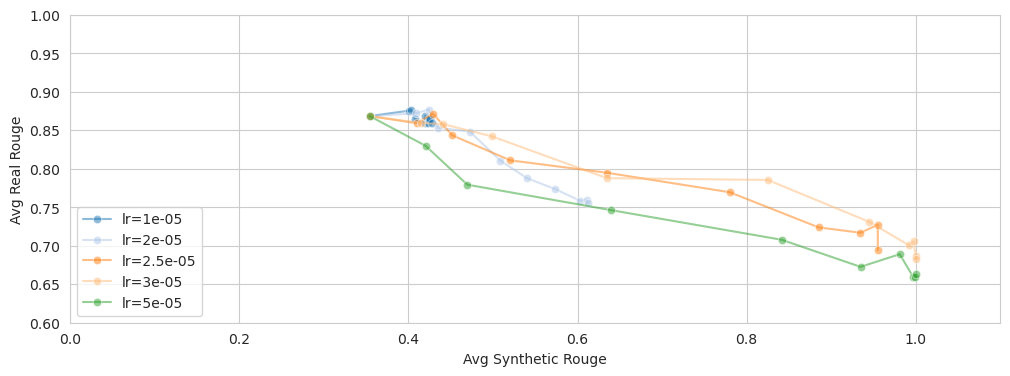

In [17]:
sns.set_style(style="whitegrid")
fig, ax = plt.subplots(figsize=(12, 4))

alpha = 0.5
palette = sns.color_palette("tab20", len(results_df.drop_duplicates(subset=['lr', 'epoch']))) # hls, husl, coolwarm, tab20

for i, (lr, epoch) in enumerate(results_df.drop_duplicates(subset=['lr', 'epoch'])[['lr', 'epoch']].values):
    layer_df = results_df[(results_df['lr'] == lr) & (results_df['epoch'] == epoch)].reset_index(drop=True)
    color = palette[i]
    sns.lineplot(x="Avg Synthetic", y="Avg Real World", data=layer_df, ax=ax, marker="o", c=color, alpha=alpha, label=f"lr={lr}")
    step = best_step(layer_df)
    text_x = layer_df["Avg Synthetic"][step//checkpoint_step-1] + 0.015
    text_y = layer_df["Avg Real World"][step//checkpoint_step-1] - 0.015
    # ax.annotate(f"{step}", (text_x, text_y), fontsize=10, color=palette[i], alpha=1, clip_on=True, zorder=2)

ax.set_xlabel("Avg Synthetic Rouge")
ax.set_ylabel("Avg Real Rouge")

plt.xlim(0, 1.1)
plt.ylim(0.6, 1)
plt.legend(loc='lower left')

# plt.xlim(0.55, 0.35)
# plt.ylim(0.8, 1)
# plt.legend(loc='lower right')

# plt.xlim(1, 0)
# plt.ylim(0, 1)

plt.show()

# save
# fig.savefig("figures/knowundo_lr_comparison.svg", format="svg")

In [112]:
def chart_over_time(results, og_results, save=None, lrs=None):
    if og_results:
        df_og = pd.read_csv(og_results)
    else:
        df_og = None
    results_df = get_results(results, df_og)

    if "tofu" in results:
        checkpoint_step = 125
    elif "knowundo" in results:
        checkpoint_step = 62

    # plot each layer on the x axis and both the retain rouge and forget rouge on the y axis
    sns.set_style(style="whitegrid")

    if lrs is None:
        lrs = results_df['lr'].unique()
    num_plots = len(lrs)

    if num_plots == 1:
        fig, axs = plt.subplots(1, 1, figsize=(6, 3), sharex=True, sharey=True)
        flat_axs = [axs]
    else:
        fig, axs = plt.subplots(num_plots, 1, figsize=(6, num_plots*2.75), sharex=True, sharey=True)
        flat_axs = axs.flat

    for i, ax in enumerate(flat_axs):
        lr = lrs[i]
        df_ = results_df[results_df['lr'] == lr].reset_index(drop=True)

        sns.lineplot(x="Step", y="ROUGE Retain", data=df_, ax=ax, marker="o", label="Retain$\\uparrow$", c="seagreen", alpha=1)
        sns.lineplot(x="Step", y="ROUGE Forget", data=df_, ax=ax, marker="o", label="Forget$\\uparrow$", c="firebrick", alpha=1)
        sns.lineplot(x="Step", y="ROUGE Real Authors", data=df_, ax=ax, marker="o", label="Real Authors$\\uparrow$", c="sandybrown", alpha=0.5)
        sns.lineplot(x="Step", y="ROUGE Real World", data=df_, ax=ax, marker="o", label="Real World$\\uparrow$", c="cornflowerblue", alpha=0.5)

        #change x axis name
        ax.set_xlabel("Finetune Step")
        ax.set_ylabel("ROUGE Score")

        if "tofu" in results:
            ax.set_xticks(np.arange(0, 1251, 125))
        elif "knowundo" in results:
            ax.set_xticks(np.arange(0, 497, 62))

        ax.set_title(f"lr={lr}")
        ax.get_legend().remove()

    ax.legend(loc='upper right', ncols=1)
    ax.legend(loc='lower right', ncols=1)

    plt.tight_layout()
    plt.show()

    if save:
        fig.savefig(save, format='svg', bbox_inches='tight')

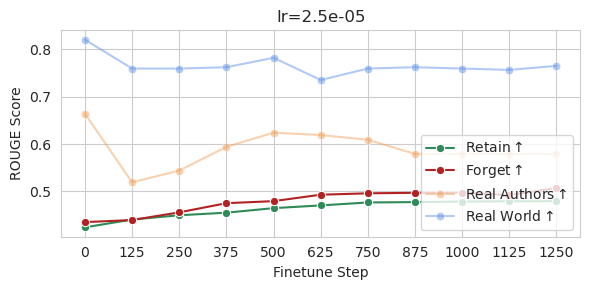

In [113]:
chart_over_time(
    results="results/phi/tofu-4000/FoT_noDS_10",
    og_results="results/phi/tofu/phi_OG_tofu_forget01_perturbed.csv",
    lrs=["2.5e-05"],
    # save="figures/knowundo_ft_noDS_charts.svg",
)

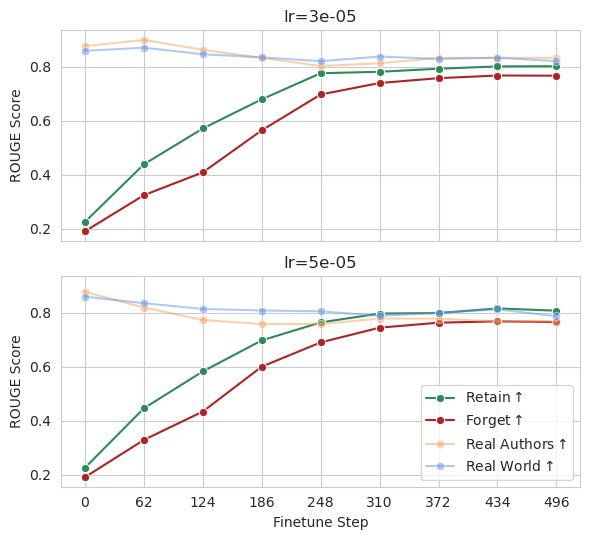

In [114]:
chart_over_time(
    results="results/qwen2-1.5b/knowundo-copyright/FoT_DS_10",
    og_results="results/qwen2-1.5b/knowundo-copyright/qwen2-1.5b_OG_unlearn.csv",
    lrs=["3e-05", "5e-05"],
    # save="figures/tofu_ft_noDS_charts.svg",
)

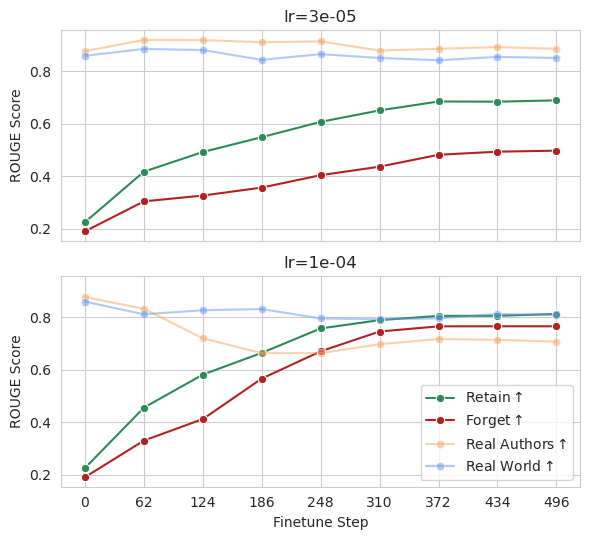

In [115]:
chart_over_time(
    results="results/qwen2-1.5b/knowundo-copyright/FoT_noDS_10",
    og_results="results/qwen2-1.5b/knowundo-copyright/qwen2-1.5b_OG_unlearn.csv",
    lrs=["3e-05", "1e-04"],
    # save="figures/tofu_ft_noDS_charts.svg",
)

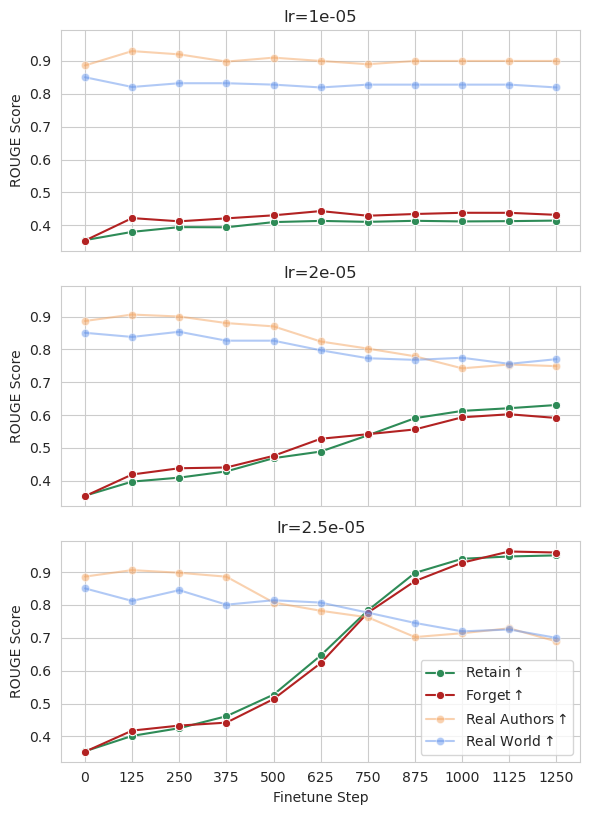

In [89]:
chart_over_time(
    results="results/qwen2-1.5b/tofu/FoT_noDS_10",
    og_results="results/qwen2-1.5b/tofu/qwen2-1.5b_OG_tofu_forget01_perturbed.csv",
    lrs=["1e-05", "2e-05", "2.5e-05"],
    # save="figures/tofu_ft_noDS_charts.svg",
)

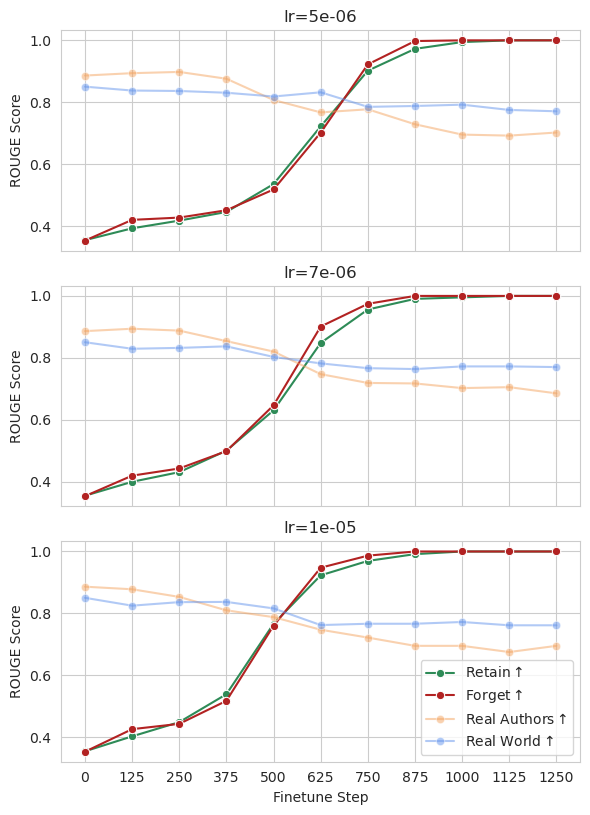

In [88]:
chart_over_time(
    results="results/qwen2-1.5b/tofu/FoT_DS_10",
    og_results="results/qwen2-1.5b/tofu/qwen2-1.5b_OG_tofu_forget01_perturbed.csv",
    lrs=None,
    # save="figures/tofu_ft_DS_charts.svg",
)

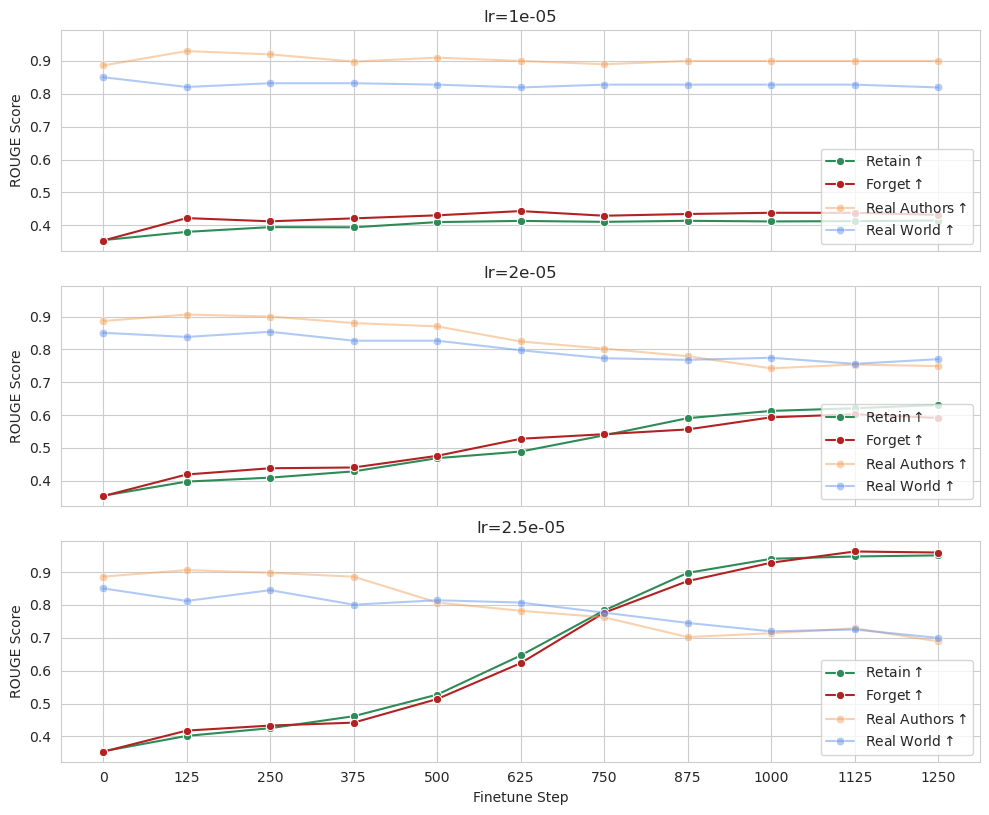

In [21]:
# plot each layer on the x axis and both the retain rouge and forget rouge on the y axis
sns.set_style(style="whitegrid")

num_plots = len(results_df['lr'].unique())
num_plots = 3
fig, axs = plt.subplots(num_plots, 1, figsize=(10, num_plots*2.75), sharex=True, sharey=True)

for i, ax in enumerate(axs.flat):
    lr = results_df['lr'].unique()[i]
    df_ = results_df[results_df['lr'] == lr].reset_index(drop=True)

    sns.lineplot(x="Step", y="ROUGE Retain", data=df_, ax=ax, marker="o", label="Retain$\\uparrow$", c="seagreen", alpha=1)
    sns.lineplot(x="Step", y="ROUGE Forget", data=df_, ax=ax, marker="o", label="Forget$\\uparrow$", c="firebrick", alpha=1)
    sns.lineplot(x="Step", y="ROUGE Real Authors", data=df_, ax=ax, marker="o", label="Real Authors$\\uparrow$", c="sandybrown", alpha=0.5)
    sns.lineplot(x="Step", y="ROUGE Real World", data=df_, ax=ax, marker="o", label="Real World$\\uparrow$", c="cornflowerblue", alpha=0.5)

    #change x axis name
    ax.set_xlabel("Finetune Step")
    ax.set_ylabel("ROUGE Score")

    # ax.set_xticks(np.arange(0, 497, 62))
    ax.set_xticks(np.arange(0, 1251, 125))

    ax.set_title(f"lr={lr}")

    ax.legend(loc='lower right', ncols=1)

plt.tight_layout()
plt.show()

# save figure as svg
# fig.savefig(f"figures/knowundo_ft_lr_charts.svg", format="svg")
# fig.savefig(f"figures/tofu_ft_noDS_charts.svg", format="svg")